Loaded 3168 samples sucessfully.
0 Female: 0.8374485596707819
0 Male 0.8989247311827957
Loaded 3168 samples sucessfully.
1 Female: 0.8463203463203464
1 Male 0.8793456032719836
Loaded 3168 samples sucessfully.
2 Female: 0.8515463917525773
2 Male 0.8626609442060086
Loaded 3168 samples sucessfully.
3 Female: 0.8698347107438017
3 Male 0.8865096359743041
Loaded 3168 samples sucessfully.
4 Female: 0.8666666666666667
4 Male 0.9044585987261147
Loaded 3168 samples sucessfully.
5 Female: 0.8362068965517241
5 Male 0.8993839835728953
Loaded 3168 samples sucessfully.
6 Female: 0.8879120879120879
6 Male 0.8991935483870968
Loaded 3168 samples sucessfully.
7 Female: 0.8807531380753139
7 Male 0.879492600422833
Loaded 3168 samples sucessfully.
8 Female: 0.8729508196721312
8 Male 0.8704103671706264
Loaded 3168 samples sucessfully.
9 Female: 0.869198312236287
9 Male 0.8972746331236897
Loaded 3168 samples sucessfully.
10 Female: 0.87117903930131
10 Male 0.8762677484787018
Loaded 3168 samples sucessfully.
1

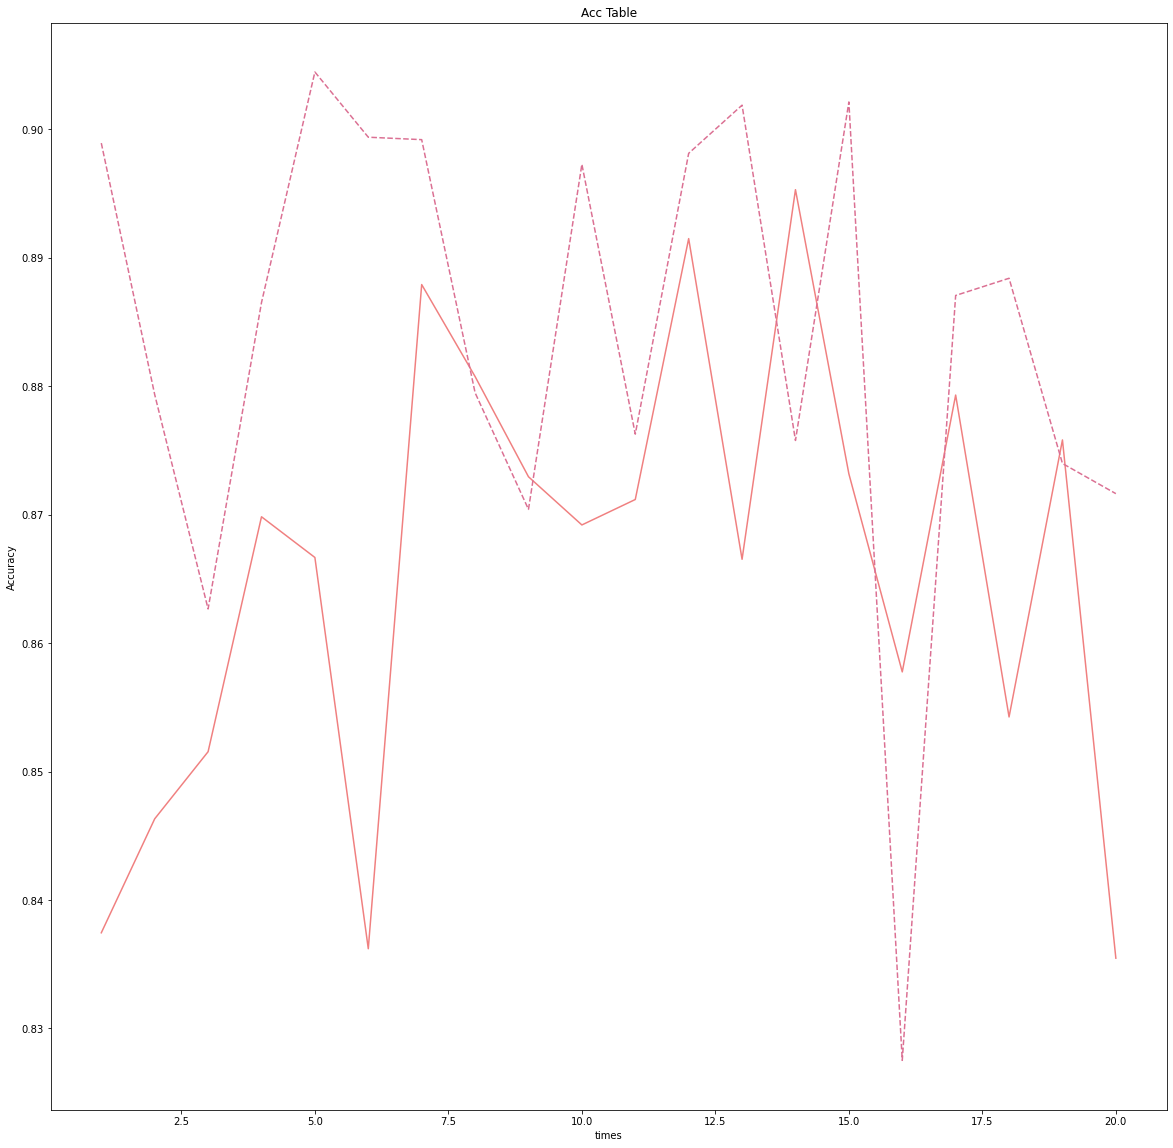

In [1]:
# coding = utf-8
import pandas as pd
import numpy as np
import random
import math
import matplotlib
from matplotlib import pyplot as plt


class bayesianClassifier(object):
        def __init__(self, ratio=0.7):

            self.trainset = []
            self.testset = []
            self.ratio = ratio

        def loadData(self, filepath):
            """
            :param filepath: csv
            :return: list
            """
            data_df = pd.read_csv(filepath)
            data_list = np.array(data_df).tolist()
            qlist=[]
            for i in range(0,20):
                a=[]
                for j in range(0,len(data_list)):
                    a.append(data_list[j][i])
                qlist.append(a)
            for i in range(0,20):
                for j in range(0,len(data_list)):
                    data_list[j][i]=math.floor(10*(data_list[j][i]-min(qlist[i]))/(max(qlist[i])-min(qlist[i])))
            #量化数据
            print("Loaded {0} samples sucessfully.".format(len(data_list)))
            self.trainset, self.testset = self.splitData(data_list)
            return data_list


        def splitData(self, data_list):
            """
            :param data_list:all data with list type
            :param ratio: train date's ratio
            :return: list type of trainset and testset
            """
            train_size = int(len(data_list) * self.ratio)
            random.shuffle(data_list)
            self.trainset = data_list[:train_size]
            self.testset = data_list[train_size:]
            return self.trainset, self.testset

        def seprateByClass(self, dataset):
            """
            :param dataset: train data with list type
            :return: seprate_dict:separated data by class;
                    info_dict:Number of samples per class(category)
            """
            seprate_dict = {}
            info_dict = {}
            for vector in dataset:
                if vector[-1] not in seprate_dict:
                    seprate_dict[vector[-1]] = []
                    info_dict[vector[-1]] = 0
                seprate_dict[vector[-1]].append(vector)
                info_dict[vector[-1]] += 1
            return seprate_dict, info_dict

        def mean(self, number_list):
            number_list = [float(x) for x in number_list]  # str to number
            return sum(number_list) / float(len(number_list))
        #均值

        def var(self, number_list):
            number_list = [float(x) for x in number_list]
            avg = self.mean(number_list)
            var = sum([math.pow((x - avg), 2) for x in number_list]) / float(len(number_list) - 1)
            return var
        #方差

        def summarizeAttribute(self, dataset):
            """
            calculate mean and var of per attribution in one class
            :param dataset: train data with list type
            :return: len(attribution)'s tuple ,that's (mean,var)  with per attribution
            """
            dataset = np.delete(dataset, -1, axis=1)  # delete label
            summaries = [(self.mean(attr), self.var(attr)) for attr in zip(*dataset)]
            return summaries
        #计算每个属性的均值和方差

        def summarizeByClass(self, dataset):
            """
            calculate all class with per attribution
            :param dataset: train data with list type
            :return: num:len(class)*len(attribution)
                    {class1:[(mean1,var1),(),...],class2:[(),(),...]...}
            """
            dataset_separated, dataset_info = self.seprateByClass(dataset)
            summarize_by_class = {}
            for classValue, vector in dataset_separated.items():
                summarize_by_class[classValue] = self.summarizeAttribute(vector)
            return summarize_by_class

        def calulateClassPriorProb(self, dataset, dataset_info):
            """
            calculate every class's prior probability
            :param dataset: train data with list type
            :param dataset_info: Number of samples per class(category)
            :return: dict type with every class's prior probability
            """
            dataset_prior_prob = {}
            sample_sum = len(dataset)
            for class_value, sample_nums in dataset_info.items():
                dataset_prior_prob[class_value] = sample_nums / float(sample_sum)
            return dataset_prior_prob

        def calculateProb(self, x, mean, var):
            """
            Continuous value using probability density function as class conditional probability
            :param x: one sample's one attribution
            :param mean: trainset's one attribution's mean
            :param var: trainset's one attribution's var
            :return: one sample's one attribution's class conditional probability
            """
            exponent = math.exp(math.pow((x - mean), 2) / (-2 * var))
            p = (1 / math.sqrt(2 * math.pi * var)) * exponent
            return p
        #由于特征种类太多，故采取概率取对数的方法来减小误差

        def calculateClassProb(self, input_data, train_Summary_by_class):
            """
            calculate class conditional probability through multiply
            every attribution's class conditional probability per class
            :param input_data: one sample vectors
            :param train_Summary_by_class: every class with every attribution's (mean,var)
            :return: dict type , class conditional probability per class of this input data belongs to which class
            """
            prob = {}
            p = 1
            for class_value, summary in train_Summary_by_class.items():
                prob[class_value] = 1
                for i in range(len(summary)):
                    mean, var = summary[i]
                    x = input_data[i]
                    p = self.calculateProb(x, mean, var)
                    p
                    prob[class_value] *= p
            return prob

        def bayesianPredictOneSample(self, input_data):
            """
            :param input_data: one sample without label
            :return: predicted class
            """
            train_separated, train_info = self.seprateByClass(self.trainset)
            prior_prob = self.calulateClassPriorProb(self.trainset, train_info)
            train_Summary_by_class = self.summarizeByClass(self.trainset)
            classprob_dict = self.calculateClassProb(input_data, train_Summary_by_class)
            result = {}
            for class_value, class_prob in classprob_dict.items():
                p = class_prob * prior_prob[class_value]
                result[class_value] = p
            return max(result, key=result.get)

        def calculateFemaleAccByBeyesian(self, ratio=0.7):
            """
            :param dataset: list type,test data
            :return: acc
            """
            self.ratio = ratio
            correct = 0
            FemaleNumber = 0
            for vector in self.testset:
                input_data = vector[:-1]
                label = vector[-1]
                if label == 'female':
                    FemaleNumber += 1
                    result = self.bayesianPredictOneSample(input_data)
                    if result == label:
                        correct += 1
            return correct / FemaleNumber
        
        def calculateMaleAccByBeyesian(self, ratio=0.7):
            """
            :param dataset: list type,test data
            :return: acc
            """
            self.ratio = ratio
            correct = 0
            MaleNumber = 0
            for vector in self.testset:
                input_data = vector[:-1]
                label = vector[-1]
                if label == 'male':
                    MaleNumber += 1
                    result = self.bayesianPredictOneSample(input_data)
                    if result == label:
                        correct += 1
            return correct / MaleNumber


if __name__ == "__main__":
        %matplotlib inline
        #通用设置
        matplotlib.rc('axes', facecolor = 'white')
        matplotlib.rc('figure', figsize = (20, 20))
        matplotlib.rc('axes', grid = False)
        #数据及线属性
        x=list(range(1,20+1))
        y_1=[]
        y_2=[]
        for i in range (0,20):
            bys = bayesianClassifier()
            data_samples = bys.loadData('D:\Voice.csv')
            print(i,"Female:",bys.calculateFemaleAccByBeyesian(ratio=0.7))
            print(i,"Male",bys.calculateMaleAccByBeyesian(ratio=0.7))
            y_1.append(bys.calculateFemaleAccByBeyesian(ratio=0.7))
            y_2.append(bys.calculateMaleAccByBeyesian(ratio=0.7))
        plt.plot(x,y_1,label="Female",color="#F08080")
        plt.plot(x,y_2,label="Male",color="#DB7093",linestyle="--")
        avg_1=sum(y_1)/len(y_1)
        avg_2=sum(y_2)/len(y_2)
        print("Average FemaleAccuracy is:", avg_1)
        print("Average MaleAccuracy is:",  avg_2)

        #标题设置
        plt.title('Acc Table')
        plt.xlabel('times')
        plt.ylabel('Accuracy')

